# Credit Card Default Demo

In [16]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model
from recourse_methods import mrmc_method
from core import recourse_iterator
from data import data_loader
from data.adapters import continuous_adapter
from models import model_utils
from core import utils
from visualize.two_d_plots import Display2DPaths

/home/jakeval/umass/research/MRMC/data/datasets/base_loader.py
/home/jakeval/umass/research/MRMC/raw_data
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pathlib
p = pathlib.Path('test/a/../b')
print(p.absolute())
print(p.parent)
print(p.parent.parent)

/home/jakeval/umass/research/MRMC/demos/test/a/../b
test/a/..
test/a


## Load the data and model

In [5]:
dataset = data_loader.load_credit_card_default_dataset()
adapter = continuous_adapter.StandardizingAdapter()
dataset

OSError: Cannot save file into a non-existent directory: '/home/jakeval/umass/research/MRMC/demos/../data/raw_data/credit_card_default'

Accuracy:  0.8179333333333333


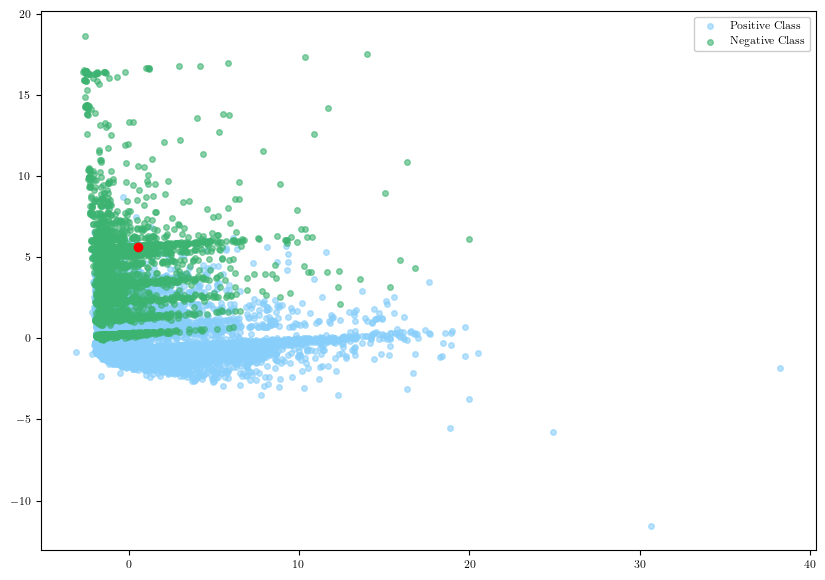

In [5]:
X = adapter.transform(dataset.drop('Y', axis=1)).copy().to_numpy()
y = dataset['Y'].copy().to_numpy()

model = linear_model.LogisticRegression(penalty='none')
model.fit(X, y)

y_pred = model.predict(X)

print("Accuracy: ", (y == y_pred).sum() / y.size)

dataset.loc[:,'Y'] = 0
dataset.loc[y_pred == 1,'Y'] = 1

poi = utils.random_poi(dataset, column='Y', label=1)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label = 0
).set_poi(adapter.transform_series(poi)).do_pca().scatter()

## Generate some recourse directions

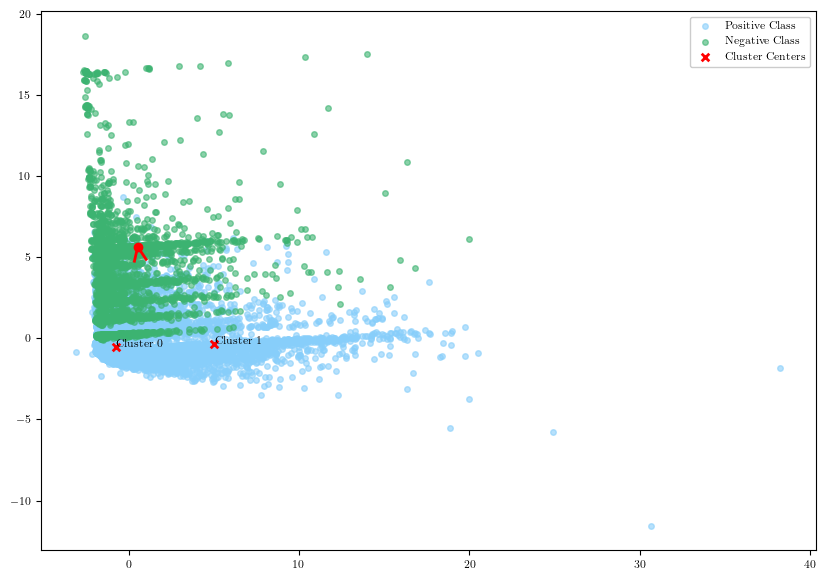

In [6]:
k_directions = 2
mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    label_column='Y',
    positive_label=0,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(1))
poix = adapter.transform_series(poi)
dirs = mrmc.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=0,
).do_pca().set_poi(poix).set_dirs(dirs, poix).set_clusters(mrmc.clusters.cluster_centers).scatter()

## Generate some paths

final certainty for path 0: 1.0
final certainty for path 1: 1.0


(<Figure size 1000x700 with 1 Axes>, <AxesSubplot:>)

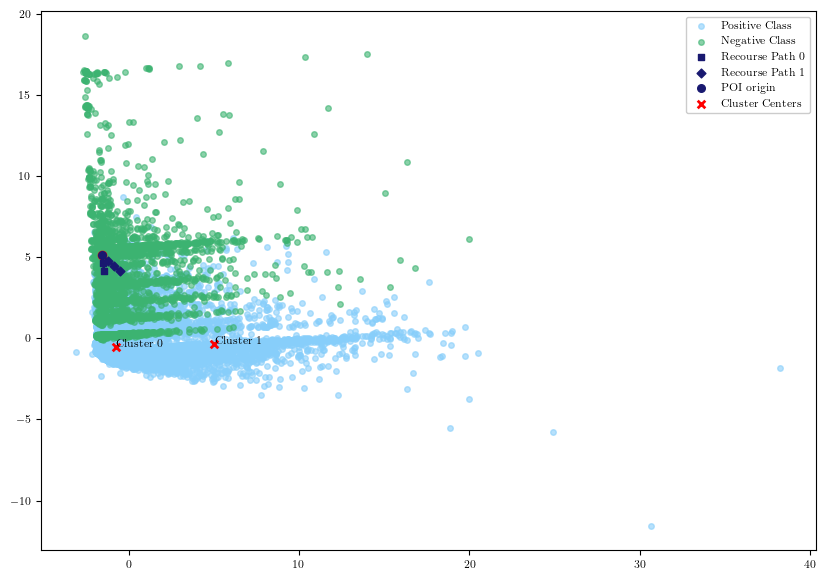

In [8]:
check_certainty = recourse_iterator.wrap_model(model, positive_index=0)

mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    label_column='Y',
    positive_label=0,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.5))

display = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=0
)

poi = utils.random_poi(dataset, column='Y', label = 1)

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    adapter,
    certainty_cutoff=0.5,
    check_certainty=check_certainty)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {check_certainty(path.iloc[-1])}')

transformed_paths = [adapter.transform(path) for path in paths]

display.do_pca().set_poi(adapter.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).scatter()

## What features are changed?

In [9]:
paths[0]

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.000000,1.000000,29.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,11586.000000,...,13913.000000,13393.000000,18152.000000,17725.000000,0.000000,3000.000000,0.000000,5000.000000,0.000000,3000.000000
1,30970.149552,1.052037,29.499405,0.926995,1.843794,1.846849,1.843426,1.839918,1.840288,12955.279872,...,14757.942951,14079.963602,18269.767191,17808.818667,320.574037,3062.332392,288.949438,4824.129393,260.388953,3013.563232
2,41860.863562,1.103894,29.994411,0.854113,1.687622,1.693568,1.686679,1.679668,1.680468,14309.717114,...,15589.247754,14753.482786,18374.921185,17879.412875,636.907435,3121.064240,573.617491,4644.877799,516.359803,3022.250623


In [10]:
paths[1]

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.000000,1.000000,29.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,11586.000000,...,13913.000000,13393.000000,18152.000000,17725.000000,0.000000,3000.000000,0.000000,5000.000000,0.000000,3000.000000
1,34181.680354,1.036717,29.450650,0.945974,1.883731,1.884586,1.884146,1.883481,1.884565,21470.698200,...,23060.706865,21852.744079,25680.575988,24952.310738,726.405188,3560.587332,621.564647,5252.974173,558.524105,3370.025676
2,48314.738334,1.073549,29.900746,0.891746,1.767142,1.768901,1.768020,1.766676,1.768874,31343.908362,...,32192.503764,30297.895807,33194.906305,32166.923907,1441.043184,4107.539465,1231.410686,5494.884010,1107.430711,3729.099501
3,62388.856690,1.110509,30.350069,0.837285,1.650186,1.652892,1.651561,1.649522,1.652873,41202.114359,...,41304.386295,38724.968197,40691.932506,39366.101047,2142.165198,4638.823333,1827.974694,5724.336961,1645.421810,4075.783309
